<a href="https://colab.research.google.com/github/Kruszylo/image_processing/blob/master/Copy_of_RPIntroNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Set up environment

1. Downloading all packages, importing them and preparing our environment
2. Remember to choose GPU runtime type

In [1]:
%matplotlib inline
!pip install --no-cache-dir -I pillow
from os import path
!pip install -q torch==1.1.0 torchvision
import torch
print(torch.__version__)
print(torch.cuda.is_available())

     |████████████████████████████████| 2.1MB 3.4MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.


     |████████████████████████████████| 676.9MB 38kB/s 
ERROR: torchvision 0.4.0 has requirement torch==1.2.0, but you'll have torch 1.1.0 which is incompatible.
1.1.0
True


In [0]:
import numpy as np
import torchvision

from matplotlib import pyplot as plt;plt.style.use('default')
from torchvision.datasets import FashionMNIST

In [4]:
! pip install tensorboardX

     |████████████████████████████████| 225kB 3.5MB/s 


In [5]:
! pip install scikit-image --upgrade

Requirement already up-to-date: scikit-image in /usr/local/lib/python3.6/dist-packages (0.15.0)


# restart your runtime!

In [0]:
! mkdir data
! mkdir tensorboard

Downloading the data, FashinMNiST, check: https://github.com/zalandoresearch/fashion-mnist and **make it automatically transformed to tensor**

In [0]:
from torchvision.transforms import ToTensor

In [10]:
ds = FashionMNIST('./data', train=True, target_transform=None, download=True, transform=ToTensor())
ds_test = FashionMNIST('./data', train=False, target_transform=None, download=True, transform=ToTensor())

0it [00:00, ?it/s]

26427392it [00:02, 11698370.38it/s]                              


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw


0it [00:00, ?it/s]

32768it [00:00, 96615.79it/s]                            
0it [00:00, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw


4423680it [00:01, 4116564.72it/s]                             
0it [00:00, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw


8192it [00:00, 31087.98it/s]            

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw
Processing...
Done!


Checking the data


**Write a code tha plots a few images, check the number of channels, shapes, samples in test and train dataset**

In [11]:
x, y = ds[1]
x.shape, y

(torch.Size([1, 28, 28]), 0)

In [12]:
len(ds)

60000

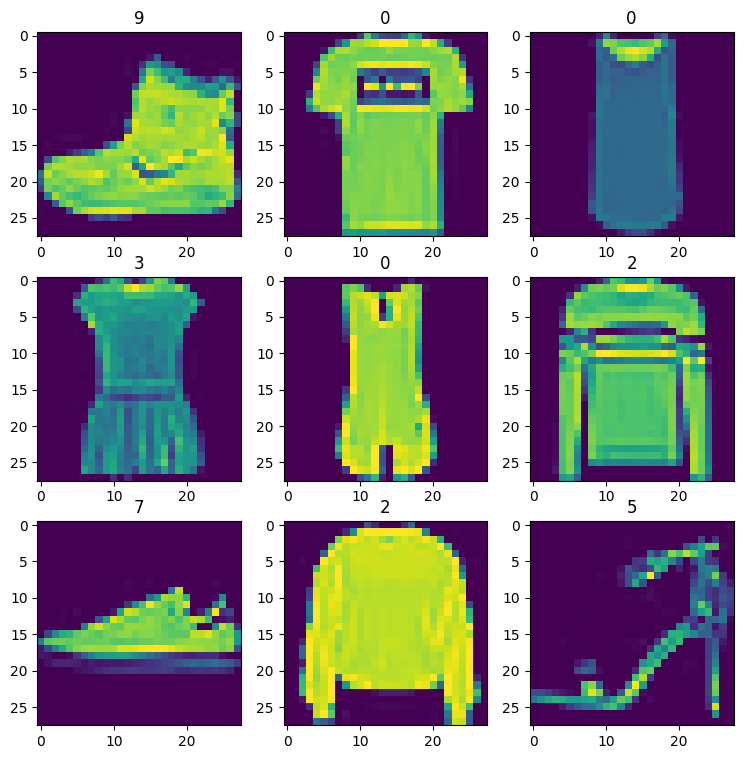

In [16]:
plt.figure(figsize=(9, 9))

for i in range(9):
    plt.subplot(331 + i ) #first and second digit - sizes of plot matrix, third - id of cell
    img, y = ds[i]
    plt.imshow(img[0])
    plt.title(y)

plt.show()

**Building** a NN

**Write a simple neural network consisted of 4 FullyConnected units and with chosen activation function**

In [0]:
from torch import functional
from torch import nn
from torch import optim


In [0]:
class SimpleNeuralNetwork(nn.Module):
    
    def __init__(self):
        super(SimpleNeuralNetwork, self).__init__()
        self.layer1 = nn.Linear(in_features = 28*28, out_features = 256)
        self.layer2 = nn.Linear(in_features = 256, out_features = 32)
        self.layer3 = nn.Linear(in_features = 32, out_features = 10)
        
    def forward(self, input_data):
        x = self.layer1(input_data.view((input_data.size(0), -1))) #we have batch of images, don't change first dim, then flatting image, we want to have vector as input
        x = nn.functional.relu(x)
        
        x = self.layer2(x)
        x = nn.functional.relu(x)
        
        x = self.layer3(x)
        x = nn.functional.softmax(x)
        
        return x

Training a NN

**Write a code which in 10 epochs train the network. zero the gradients, calculate loss and make a backward step optimization.**

**Remember to define optimizer, criterion and to monitor loss using simple print function provided**

In [0]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from torch.utils.data import DataLoader

In [0]:
batch_size = 1024

In [0]:
train_dl = DataLoader(ds, batch_size, shuffle=True)
valid_dl = DataLoader(ds_test, batch_size, shuffle=True)

In [0]:
model = SimpleNeuralNetwork()
model = model.cuda()

In [24]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(params = model.parameters(), lr = 0.1)
print(model)
number_of_epochs = 10

SimpleNeuralNetwork(
  (layer1): Linear(in_features=784, out_features=256, bias=True)
  (layer2): Linear(in_features=256, out_features=32, bias=True)
  (layer3): Linear(in_features=32, out_features=10, bias=True)
)


In [26]:
import torch
model.parameters()

<generator object Module.parameters at 0x7f0886d96d58>

In [32]:
some_index = 0
for i in range(number_of_epochs):
    train_loss = 0
    for iteration, sample in enumerate(train_dl):
        imgs, y = sample
        if torch.cuda.is_available():
          imgs = imgs.cuda()
          y = y.cuda()
          
        model.zero_grad()
        output_data = model(imgs)
        loss = criterion(output_data, y)
        loss.backward()
        optimizer.step() #update weights 
        train_loss += loss.item() / imgs.size(0) #devide by bios size
        
    val_loss = 0
    y_predicted = []
    y_true = []

    # disable gradinet calculations
    with torch.no_grad():
        for iteration, sample in enumerate(valid_dl):
          imgs, y = sample
          if torch.cuda.is_available():
            imgs = imgs.cuda()
            y = y.cuda()
          
          output_data = model(imgs)
          loss = criterion(output_data, y)
          train_loss += loss.item() / imgs.size(0) #devide by bios size
          y_true.extend(y.cpu().tolist())
          _, predicted_ind = torch.max(output_data, dim=1)
          y_predicted.extend(predicted_ind.cpu().tolist())

            
    val_acc = accuracy_score(y_true, y_predicted)
    print('#Epoch: {}, train loss: {}, val loss: {}, val_acc: {}'.format(i, train_loss, val_loss, val_acc))
    

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


#Epoch: 0, train loss: 0.15738671674632201, val loss: 0, val_acc: 0.1
#Epoch: 1, train loss: 0.15738678033634715, val loss: 0, val_acc: 0.1
#Epoch: 2, train loss: 0.15738642258943727, val loss: 0, val_acc: 0.1
#Epoch: 3, train loss: 0.15738716459418944, val loss: 0, val_acc: 0.1
#Epoch: 4, train loss: 0.15738618971902987, val loss: 0, val_acc: 0.1
#Epoch: 5, train loss: 0.15738697464839943, val loss: 0, val_acc: 0.1
#Epoch: 6, train loss: 0.15738726686511215, val loss: 0, val_acc: 0.1
#Epoch: 7, train loss: 0.1573871542653619, val loss: 0, val_acc: 0.1
#Epoch: 8, train loss: 0.1573872918980326, val loss: 0, val_acc: 0.1
#Epoch: 9, train loss: 0.15738720089551284, val loss: 0, val_acc: 0.1



## Simple CNN model

**Define a conv block that contains 2 convolution operations and than MaxPooling (ot any other Pooling), convolution should preserve the image shape!**

**Finish the network with 3 Fully Connected layers**


In [0]:
class SimpleConvNeuralNetwork(nn.Module):
    
    def __init__(self):
        super(SimpleConvNeuralNetwork, self).__init__()
        #TODO
        
    def forward(self, input_data):
        
        #TODO
        return x


**Define params for training and train the model for 10 epochs**

In [0]:
batch_size = 1024
train_dl = DataLoader(#TODO)
valid_dl = DataLoader(#TODO)
model = SimpleConvNeuralNetwork()
model = model.cuda()

criterion = #TODO
optimizer = #TODO
print(model)
number_of_epochs = 10

In [0]:
some_index = 0
for i in range(number_of_epochs):
    train_loss = 0
    for iter, sample in enumerate(train_dl):
        #TODO
        
    val_loss = 0
    y_predicted = []
    y_true = []

    # disable gradinet calculations
    with torch.no_grad():
        for iteration, sample in enumerate(valid_dl):
            #TODO
            
    val_acc = accuracy_score(y_true, y_predicted)
    print('#Epoch: {}, train loss: {}, val loss: {}, val_acc: {}'.format(i, train_loss, val_loss, val_acc))
    

**Write LeNet-5 classifier and train it https://engmrk.com/lenet-5-a-classic-cnn-architecture/**

In [0]:
#TODO